# Palleja & Suez GMM baseline random forest, using interpolated data!!!
## Using vegdist (Bray-Curtis)
## LHS is "distance * day", not distance!!
## Time points are realgined between Suez and Palleja!!

## 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Jessica/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
species = pd.read_csv("/Users/Jessica/Documents/Lab/Multiple_longitudinal/Microbe_resilience/Interpolate_missing_timepoint/Palleja_Suez_GMM_baseline_vegdist_bray_interpolated_realigned_timepoint_forML.txt",
                   delimiter = "\t")

In [3]:
species.head()

,Sample_id,recovered_realigned_day,lowest_dist,DistxDay,Timepoint_realign,Study,Perturbance_scale,MF0001,MF0002,MF0003,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,801,56,0.065118,3.646622,Baseline,Suez,0.150623,104,71,66,...,158,59,22,76,8,4,11,8,104,34
1,802,52,0.048234,2.508186,Baseline,Suez,0.150256,82,55,69,...,164,87,22,94,1,31,21,11,66,55
2,803,31,0.054971,1.704094,Baseline,Suez,0.079068,87,50,82,...,177,85,39,89,5,6,18,3,74,43
3,804,5,0.038956,0.194780,Baseline,Suez,0.078213,79,53,74,...,169,98,15,92,2,19,18,8,79,53
4,805,56,0.062680,3.510108,Baseline,Suez,0.147491,82,50,85,...,164,83,25,86,1,14,19,4,105,44


## 2. Set up evaluation environment. Use stratified 5-fold CV to determine the accuracy of the model

In [4]:
my_data = species.drop(columns=['recovered_realigned_day', 'lowest_dist', 'Timepoint_realign', 'Study'])

In [5]:
my_data.head()

,Sample_id,DistxDay,Perturbance_scale,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,801,3.646622,0.150623,104,71,66,3,20,15,94,...,158,59,22,76,8,4,11,8,104,34
1,802,2.508186,0.150256,82,55,69,3,25,9,88,...,164,87,22,94,1,31,21,11,66,55
2,803,1.704094,0.079068,87,50,82,2,23,10,107,...,177,85,39,89,5,6,18,3,74,43
3,804,0.194780,0.078213,79,53,74,2,16,14,110,...,169,98,15,92,2,19,18,8,79,53
4,805,3.510108,0.147491,82,50,85,2,23,11,94,...,164,83,25,86,1,14,19,4,105,44


In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

## Step 3: Try out Random Forest (within the 5 - Fold CV setup)

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from collections import OrderedDict

In [9]:
seed = 42

In [10]:
X, y = my_data.drop(columns=['Sample_id', 'DistxDay']), my_data.DistxDay

In [11]:
X.head()

,Perturbance_scale,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,MF0009,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,0.150623,104,71,66,3,20,15,94,94,6,...,158,59,22,76,8,4,11,8,104,34
1,0.150256,82,55,69,3,25,9,88,88,23,...,164,87,22,94,1,31,21,11,66,55
2,0.079068,87,50,82,2,23,10,107,108,6,...,177,85,39,89,5,6,18,3,74,43
3,0.078213,79,53,74,2,16,14,110,110,14,...,169,98,15,92,2,19,18,8,79,53
4,0.147491,82,50,85,2,23,11,94,94,8,...,164,83,25,86,1,14,19,4,105,44


In [12]:
# All the methods to be compared
ensemble_clfs = [
    ("RF, max_features='sqrt', max_depth = 2",
       RandomForestRegressor(random_state=seed, max_depth=2,
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='sqrt', max_depth = 5",
       RandomForestRegressor(random_state=seed, max_depth=5, 
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='sqrt', max_depth = 10",
       RandomForestRegressor(random_state=seed, max_depth=10, 
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='log2', max_depth = 2",
       RandomForestRegressor(random_state=seed, max_depth=2, 
                            oob_score=True, max_features = "log2")),
    ("RF, max_features='log2', max_depth = 5",
       RandomForestRegressor(random_state=seed, max_depth=5, 
                            oob_score=True, max_features = "log2")),
    ("RF, max_features='log2', max_depth = 10",
       RandomForestRegressor(random_state=seed, max_depth=10,
                            oob_score=True, max_features = "log2"))
     ]

In [14]:
# OOB error
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 25
max_estimators = 1500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 25):
        clf.set_params(n_estimators=i, n_jobs = 2)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

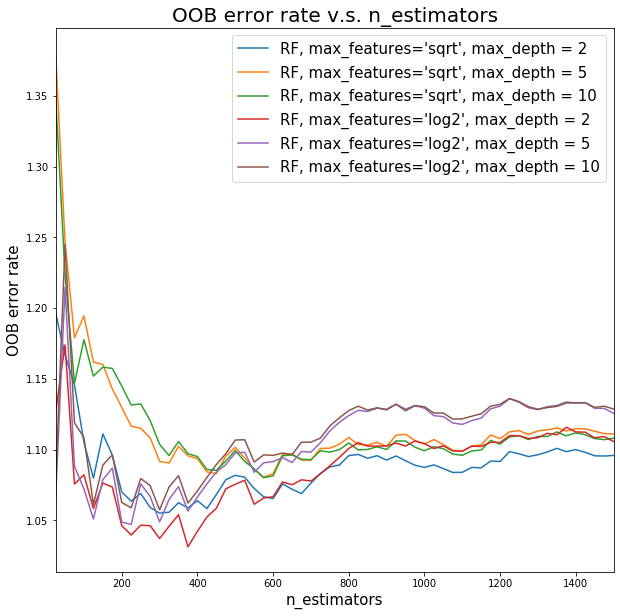

In [17]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.rcParams["figure.figsize"] = [40, 40]
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 15)
plt.title("OOB error rate v.s. n_estimators", fontsize = 20)
plt.show()

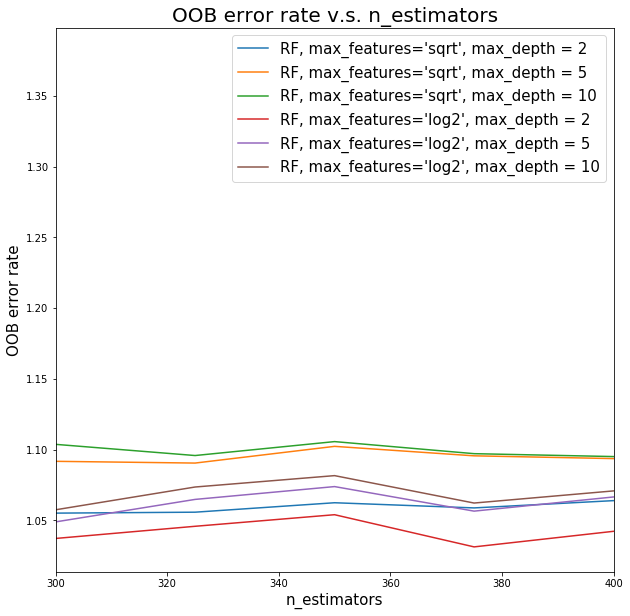

In [19]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.rcParams["figure.figsize"] = [10, 10]
plt.xlim(300, 400)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 15)
plt.title("OOB error rate v.s. n_estimators", fontsize = 20)
plt.show()

**From the plot above, we can see that the blue line at 375 estimators is the best, but I chose red line at 1150 because it's more stable there.**

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import random
import math
seed = 42
X, y = my_data.drop(columns=['Sample_id', 'DistxDay']), my_data.DistxDay
kf = KFold(n_splits=5)

In [21]:
# Max_depth = 2, max_features = "log2"
RF_1 = RandomForestRegressor(random_state=seed, max_depth=2, n_estimators= 375, 
                            oob_score=True, max_features = "log2")
result_negMSE_1 = cross_val_score(RF_1, X, y, cv = kf, scoring="neg_mean_absolute_error")
print("Avg kfold neg MSE: {}".format(result_negMSE_1.mean())) #Print average accuracy
output = cross_validate(RF_1, X, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator =True)

Avg kfold neg MSE: -1.401224528909453


### Calculate the feature importance per fold

In [22]:
# Get feature importance per estimator
feature_result = []
for idx, estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_, index = X.columns, 
                                       columns=['importance']).sort_values('importance', ascending=False)
    feature_result.append((feature_importances)) # Save the result in each loop to feature_result
    #print(feature_importances)


Features sorted by their score for estimator 0:
Features sorted by their score for estimator 1:
Features sorted by their score for estimator 2:
Features sorted by their score for estimator 3:
Features sorted by their score for estimator 4:


In [23]:
type(feature_result)

list

In [24]:
feature_result_1 = pd.DataFrame(feature_result[0])
feature_result_2 = pd.DataFrame(feature_result[1])
feature_result_3 = pd.DataFrame(feature_result[2])
feature_result_4 = pd.DataFrame(feature_result[3])
feature_result_5 = pd.DataFrame(feature_result[4])
feature_result_all = pd.concat([feature_result_1, feature_result_2, feature_result_3, 
                              feature_result_4, feature_result_5])

In [25]:
feature_result_all

,importance
MF0120,0.036492
MF0103,0.028697
MF0019,0.025442
MF0020,0.025080
MF0035,0.023939
...,...
MF0133,0.000153
MF0094,0.000128
MF0069,0.000108
MF0128,0.000000


In [26]:
# Turn rownames to colum
feature_result_all.index.name = 'Feature'
feature_result_all.reset_index(inplace=True)
feature_result_all.head(10)


,Feature,importance
0,MF0120,0.036492
1,MF0103,0.028697
2,MF0019,0.025442
3,MF0020,0.025080
4,MF0035,0.023939
5,MF0033,0.023537
6,MF0058,0.023232
7,MF0091,0.021724
8,MF0087,0.021076
9,Perturbance_scale,0.019025


In [27]:
# Select only the top 10 important features for plotting
feature_result_all.sort_values(by = "importance", ascending=False, inplace=True)

# Group features and compute the median of each group 
#https://www.kite.com/python/answers/how-to-group-a-pandas-dataframe-by-a-column-and-compute-the-mean-of-each-group-in-python
grouped_feature_result_all = feature_result_all.groupby("Feature")
mean_feature = grouped_feature_result_all.median()
mean_feature = mean_feature.reset_index() #reset index to match format

# Sort by importance
mean_feature.sort_values(by = "importance", ascending=False, inplace=True)
mean_feature.head(10)

,Feature,importance
18,MF0019,0.025442
19,MF0020,0.025080
130,Perturbance_scale,0.024127
99,MF0103,0.019762
88,MF0091,0.018387
7,MF0008,0.017532
73,MF0076,0.016253
10,MF0011,0.015625
70,MF0072,0.014963
93,MF0097,0.014911


In [28]:
mean_feature.loc[25, ][0]

'MF0026'

In [29]:
feature_plotting = feature_result_all.loc[feature_result_all['Feature'].isin
                                          ([mean_feature.loc[18, ][0], mean_feature.loc[19, ][0],
                                           mean_feature.loc[130, ][0], mean_feature.loc[99, ][0],
                                           mean_feature.loc[88, ][0], mean_feature.loc[7, ][0],
                                           mean_feature.loc[73, ][0], mean_feature.loc[10, ][0],
                                           mean_feature.loc[70, ][0], mean_feature.loc[93, ][0]])]
feature_plotting.head()

,Feature,importance
262,MF0091,0.047043
131,MF0076,0.036432
525,MF0019,0.034692
526,MF0020,0.034039
527,Perturbance_scale,0.033152


In [32]:
# Manually sort the plotting order
order_list = [mean_feature.loc[18, ][0], mean_feature.loc[19, ][0],
                                           mean_feature.loc[130, ][0], mean_feature.loc[99, ][0],
                                           mean_feature.loc[88, ][0], mean_feature.loc[7, ][0],
                                           mean_feature.loc[73, ][0], mean_feature.loc[10, ][0],
                                           mean_feature.loc[70, ][0], mean_feature.loc[93, ][0]]

In [33]:
order_list

['MF0019',
 'MF0020',
 'Perturbance_scale',
 'MF0103',
 'MF0091',
 'MF0008',
 'MF0076',
 'MF0011',
 'MF0072',
 'MF0097']

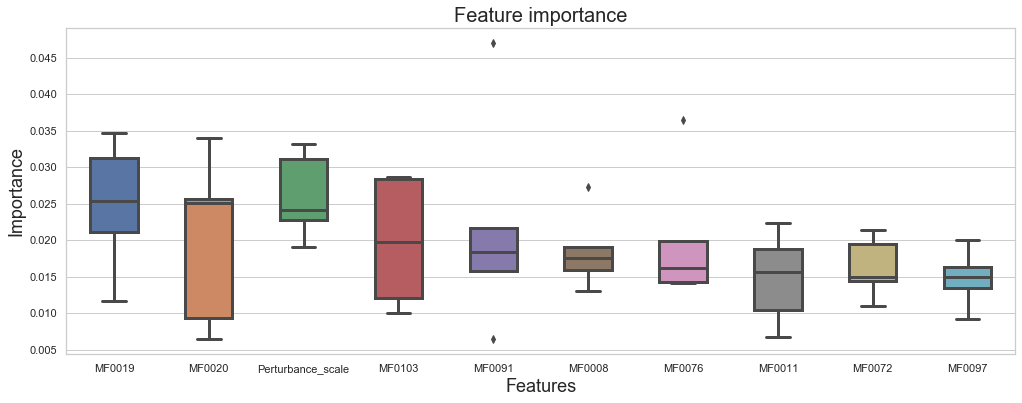

In [34]:
# Plot boxplot to see the variation of feature importance across folds 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(17,6)})
sns.set_style("whitegrid")
a = sns.boxplot(x=feature_plotting["Feature"], y=feature_plotting["importance"], 
                width=0.5, linewidth=3, order = order_list)
a.axes.set_title("Feature importance",fontsize=20)
a.set_xlabel("Features",fontsize=18)
a.set_ylabel("Importance",fontsize=18)
a.set_xticklabels(a.get_xticklabels(),rotation = 0)
#a.set_xticklabels(["Prevotella.copri", "Prevotella.sp.incertae.sedis",
#                  "Roseburia.intestinalis", "Ruminococcus.sp.incertae.sedis",
#                  "Bacteroides.caecimuris", 
#                  "Faecalibacterium.prausnitzii_uncultured", "Ruminococcus sp.", 
#                  "Lachnospiraceae.sp.incertae.sedis", "Bifidobacterium.ruminantium", 
#                  "Faecalibacterium sp."])
plt.show()
